In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import geopandas as gpd
from functools import reduce
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import matplotlib.patches as mpatches
import warnings
import random
warnings.filterwarnings("ignore")

Below are sections **Data Cleaning**, **Dimension Reduction**, **XGBoost Regression for Demand Prediction**, **SHAP Value Analysis1**,  **XGBoost Regression for Revenue Prediction**, **SHAP Value Analysis2**, and **Pricing Model**

## Data Cleaning

In [2]:
class Data():
    def __init__(self, dfs):
        self.original_dfs = dfs
        self.dfs = dfs
        self.cleaned = False
        self.output = None
        
    def clean(self):
        if self.cleaned:
            return
        for i in range(len(self.dfs)):
            self.dfs[i] = self.dfs[i][self.dfs[i]["availability_30"] > 0]
            self.dfs[i]['occupancy_rate'] =(30 - self.dfs[i]['availability_30']) / 30
            self.dfs[i]["price"] = self.dfs[i]["price"].apply(lambda x: float(x.replace(',','')[1:]))

        merged_df = reduce(lambda left,right: pd.merge(left, right[['id', 'price', 'occupancy_rate']],on='id', how = 'inner', suffixes=('_x', '_y')), self.dfs)
        price_demand = merged_df[['id','price_x', 'price_y', 'occupancy_rate_x', 'occupancy_rate_y']]
        price_demand.columns = ['id','price_1','price_2','price_3','price_4', 'demand_1', 'demand_2', 'demand_3', 'demand_4']
        price_demand = price_demand.merge(df1[['id', 'reviews_per_month']], on='id', how = 'inner').dropna()
        price_demand['demand'] = 1/4*(price_demand['demand_1'] + price_demand['demand_2'] + price_demand['demand_3'] + price_demand['demand_4'])
        price_demand['price'] = 1/4*(price_demand['price_1'] + price_demand['price_2'] + price_demand['price_3'] + price_demand['price_4'])
        df_21 = price_demand.drop(['price_1', "price_2", "price_3", "price_4", 'demand_1', "demand_2", "demand_3", "demand_4"], axis=1).merge(df1[["id", "neighbourhood_cleansed", "bedrooms", "beds", "room_type", "minimum_nights", "amenities", "property_type", "listing_url", 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', "host_since", "calculated_host_listings_count", "accommodates"]], how = 'inner', on=['id'])
        df_21 = df_21[df_21['minimum_nights'] <= 100]
        df_21 = df_21[df_21['demand'] > 0]
        self.output = df_21
        self.dfs = self.original_dfs
        
        
    def add(self, name, func):
        self.output[name] = func(self.output)
        return
    
    def get(self):
        return self.output
    
    def original(self):
        return self.original_dfs
    
    def dropna(self, columns):
        self.output = self.output.dropna(subset=columns)
        return

In [3]:
df1 = pd.read_csv('Data/listings3.csv')
df2 = pd.read_csv('Data/listings6.csv')
df3 = pd.read_csv('Data/listings9.csv')
df4 = pd.read_csv('Data/listings12.csv')
dfs = [df1, df2, df3, df4]


In [4]:
data = Data(dfs)

In [5]:
data.clean()
data.add("price_per_person", lambda x: x['price']/x['accommodates'])
data.dropna(['room_type', "price_per_person", "review_scores_rating", "accommodates", "room_type"])

In [6]:
df = data.get()

In [7]:
df['log_demand'] = np.log((df['demand'])/(1-df['demand']))

<AxesSubplot:>

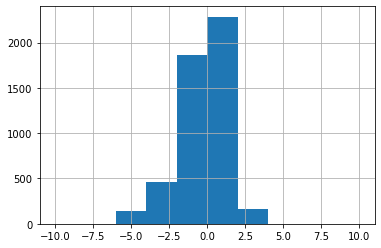

In [8]:
df.replace([np.inf, -np.inf], -50, inplace=True)
df['log_demand'].hist(range=(-10,10))

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder

In [10]:
df = data.get()

In [11]:
df = df.dropna()

In [12]:
df.columns

Index(['id', 'reviews_per_month', 'demand', 'price', 'neighbourhood_cleansed',
       'bedrooms', 'beds', 'room_type', 'minimum_nights', 'amenities',
       'property_type', 'listing_url', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'host_since',
       'calculated_host_listings_count', 'accommodates', 'price_per_person',
       'log_demand'],
      dtype='object')

In [13]:
len(df.columns)

24

#### Zillow Housing data Zipcode Merge

In [14]:
import geopy

In [15]:
neighborhood_location = df1.groupby('neighbourhood_cleansed').mean()[['longitude', 'latitude']]

In [16]:
neighborhood_location = np.round(neighborhood_location[['longitude','latitude']], 5)

In [17]:
def get_zipcode(df, geolocator, lat_field, lon_field):
    location = geolocator.reverse((df[lat_field], df[lon_field]))
    if 'postcode' in location.raw['address'].keys():
        return location.raw['address']['postcode']
    else:
        return 0


geolocator = geopy.Nominatim(user_agent='Jiayang_Nie')

zipcodes = neighborhood_location.apply(get_zipcode, axis=1, geolocator=geolocator, lat_field='latitude', lon_field='longitude')

In [18]:
zipcodes['Agua Dulce'] = '91390'
zipcodes['Angeles Crest'] = '91011'
zipcodes['Ridge Route'] = '93225'
zipcodes['Tujunga Canyons'] = '91042'
zipcodes['Unincorporated Catalina Island'] = '90704'
zipcodes['Unincorporated Santa Susana Mountains'] = '93063'
zipcodes['Leona Valley'] = '93551'

In [19]:
zipcodes = zipcodes.apply(lambda x: x[0:5]).astype(int)

In [20]:
zipcodes = zipcodes.to_frame().reset_index()
zipcodes.columns = ['neighbourhood_cleansed', 'zipcode']

In [21]:
zipcodes

neighbourhood_cleansed  zipcode
0                    Acton    93510
1          Adams-Normandie    90007
2             Agoura Hills    91301
3               Agua Dulce    91390
4                 Alhambra    91801
..                     ...      ...
258            Willowbrook    90059
259             Wilmington    90744
260         Windsor Square    90004
261               Winnetka    91306
262         Woodland Hills    91364

[263 rows x 2 columns]

In [22]:
df = pd.merge(df, zipcodes, on = 'neighbourhood_cleansed')

In [23]:
one_bed = pd.read_csv("Data/zillow_1bed.csv")
two_bed = pd.read_csv("Data/zillow_2bed.csv")
three_bed = pd.read_csv("Data/zillow_3bed.csv")
four_bed = pd.read_csv("Data/zillow_4bed.csv")
five_bed = pd.read_csv("Data/zillow_5bed.csv")

In [24]:
def look_for(row):
    nbeds = row['bedrooms']
    zipcode = row['zipcode']
    if nbeds == 1:
        toReturn = one_bed[one_bed['RegionID'] == zipcode]['2021-12-31']
    elif nbeds == 2:
        toReturn = two_bed[two_bed['RegionID'] == zipcode]['2021-12-31']
    elif nbeds == 3:
        toReturn = three_bed[three_bed['RegionID'] == zipcode]['2021-12-31']
    elif nbeds == 4:
        toReturn = four_bed[four_bed['RegionID'] == zipcode]['2021-12-31']
    else:
        toReturn = five_bed[five_bed['RegionID'] == zipcode]['2021-12-31']
    while toReturn.empty:
        zipcode += 1
        if nbeds == 1:
            toReturn = one_bed[one_bed['RegionID'] == zipcode]['2021-12-31']
        elif nbeds == 2:
            toReturn = two_bed[two_bed['RegionID'] == zipcode]['2021-12-31']
        elif nbeds == 3:
            toReturn = three_bed[three_bed['RegionID'] == zipcode]['2021-12-31']
        elif nbeds == 4:
            toReturn = four_bed[four_bed['RegionID'] == zipcode]['2021-12-31']
        else:
            toReturn = five_bed[five_bed['RegionID'] == zipcode]['2021-12-31']
    return toReturn.iloc[0]

a = df.apply(look_for, axis=1)
            
            
            

In [25]:
df['housing_price'] = a

## Dimension Reduction

We performed dimension reduction using principal component analysis to reduce the time and storage space required. It also helps remove multi-collinearity which improves the interpretation of the parameters of the machine learning model. We one encoded the variable property type and reduced the dimensionality of the amenities column.

In [26]:
import tensorflow as tf
from tensorflow.keras import layers
from gensim.models import Word2Vec, KeyedVectors
from spacy.lang.en import English

In [27]:
from sklearn.decomposition import PCA
from prince import MCA

In [28]:
enc_ohe = OneHotEncoder()
enc_ohe.fit(df[["property_type"]])
property_types = pd.DataFrame(enc_ohe.transform(df[["property_type"]]).toarray(), columns=enc_ohe.get_feature_names(['property_type']))

In [29]:
property_types

property_type_Barn  property_type_Boat  property_type_Camper/RV  \
0                    0.0                 0.0                      0.0   
1                    0.0                 0.0                      0.0   
2                    0.0                 0.0                      0.0   
3                    0.0                 0.0                      0.0   
4                    0.0                 0.0                      0.0   
...                  ...                 ...                      ...   
4275                 0.0                 0.0                      0.0   
4276                 0.0                 0.0                      0.0   
4277                 0.0                 0.0                      0.0   
4278                 0.0                 0.0                      0.0   
4279                 0.0                 0.0                      0.0   

      property_type_Castle  property_type_Earth house  \
0                      0.0                        0.0   
1                      0.0                        0.0   
2                      0.0                        0.0   
3                      0.0                        0.0   
4                      0.0                        0.0   
...                    ...                        ...   
4275                   0.0                        0.0   
4276                   0.0                        0.0   
4277                   0.0                        0.0   
4278                   0.0                        0.0   
4279                   0.0                        0.0   

      property_type_Entire apartment  property_type_Entire bungalow  \
0                                0.0                            0.0   
1                                0.0                            1.0   
2                                0.0                            0.0   
3                                0.0                            1.0   
4                                0.0                            0.0   
...                              ...                            ...   
4275                             0.0                            0.0   
4276                             0.0                            0.0   
4277                             0.0                            0.0   
4278                             0.0                            0.0   
4279                             0.0                            0.0   

      property_type_Entire cabin  property_type_Entire condominium  \
0                            0.0                               0.0   
1                            0.0                               0.0   
2                            0.0                               0.0   
3                            0.0                               0.0   
4                            0.0                               0.0   
...                          ...                               ...   
4275                         0.0                               0.0   
4276                         0.0                               0.0   
4277                         0.0                               0.0   
4278                         0.0                               0.0   
4279                         0.0                               0.0   

      property_type_Entire cottage  ...  \
0                              0.0  ...   
1                              0.0  ...   
2                              0.0  ...   
3                              0.0  ...   
4                              0.0  ...   
...                            ...  ...   
4275                           0.0  ...   
4276                           0.0  ...   
4277                           0.0  ...   
4278                           0.0  ...   
4279                           0.0  ...   

      property_type_Shared room in guesthouse  \
0                                         0.0   
1                                         0.0   
2                                         0.0   
3                                    

In [30]:
mca_property = MCA(n_components = 10, n_iter = 100, random_state = 101)
mca_property.fit(property_types)
property_mca = mca_property.transform(property_types)
property_mca.head()

0         1         2         3         4         5         6  \
0 -0.126122 -0.927554 -0.051703  0.146164 -0.063164 -0.179413 -0.424887   
1 -0.263761 -0.490672 -0.868940  0.171333  0.414497 -1.548417 -0.042145   
2 -0.263968  0.062833 -0.277506 -0.070577 -0.014518  0.211227  0.412477   
3 -0.263761 -0.490672 -0.868940  0.171333  0.414497 -1.548417 -0.042145   
4  0.231014  0.278695  0.295051  0.053823 -0.139652  0.031017 -0.058203   

          7         8         9  
0 -0.121227 -0.165789 -0.821431  
1 -1.084343 -1.113502 -0.620541  
2  0.084862  0.045319 -0.114095  
3 -1.084343 -1.113502 -0.620541  
4 -0.428125 -0.523333 -0.239162

In [31]:
property_mca.columns = ["property_"+str(i) for i in range(10)]

In [32]:
df = pd.concat([df.reset_index(drop=True), property_mca], axis=1).drop("property_type", axis=1)

In [33]:
amen = {}
stop_words = set([' ', '!', '"', '$', '%', '&', "'s", '(', ')', '*', '+', ',','-','--','-rain','.','/','0','1','10','100','1000','100\\','12','125\\','14','140','15\\','180','184','196','2','200','25','26','260','3','300','30\\','32\\','33\\','360','365','4','400','40\\','42\\','43\\','44\\','45','45\\','46\\','48\\','5','50','500','50\\','54\\','55\\','58\\','6','60\\','65\\','70','72\\','75','75\\','8',':',';','\\u2013','\\u2013\\u00a0','\\u2019n', 'a'])
nlp = English()
for amenity in df['amenities']:
    
    amenity = amenity[2:-2].split('", "')
    for a in amenity:
        a = a.lower()
        tokens = nlp(a)
        for token in tokens:
            token = str(token)
            if token in stop_words:
                continue
            elif token not in amen:
                amen[token] = 1
            else:
                amen[token] += 1


In [34]:
threshold = np.quantile(list(amen.values()), 0.75)
amens = []
for key in amen.keys():
    if amen[key] >= threshold:
        amens.append(key)

In [35]:
amens

['stove',
 'cooking',
 'basics',
 'bathtub',
 'kitchen',
 'hangers',
 'essentials',
 'iron',
 'oven',
 'heating',
 'hair',
 'dryer',
 'long',
 'term',
 'stays',
 'allowed',
 'hot',
 'water',
 'lock',
 'on',
 'bedroom',
 'door',
 'dedicated',
 'workspace',
 'smoke',
 'alarm',
 'refrigerator',
 'shampoo',
 'host',
 'greets',
 'you',
 'dishes',
 'and',
 'silverware',
 'carbon',
 'monoxide',
 'wifi',
 'free',
 'street',
 'parking',
 'first',
 'aid',
 'kit',
 'garden',
 'or',
 'backyard',
 'patio',
 'balcony',
 'washer',
 'in',
 'tv',
 'coffee',
 'maker',
 'fire',
 'extinguisher',
 'bed',
 'linens',
 'luggage',
 'dropoff',
 'extra',
 'pillows',
 'blankets',
 'paid',
 'premises',
 'bbq',
 'grill',
 'microwave',
 'beach',
 'cable',
 'single',
 'level',
 'home',
 'private',
 'entrance',
 'cleaning',
 'before',
 'checkout',
 'keypad',
 'air',
 'conditioning',
 'indoor',
 'fireplace',
 'pack',
 'play',
 'travel',
 'crib',
 'children\\u2019s',
 'books',
 'toys',
 'high',
 'chair',
 'dishwasher',


In [36]:
amenities = np.zeros((df.shape[0], len(amens)))
for i in range(len(df['amenities'])):
    for j in range(len(amens)):
        if amens[j] in df['amenities'][i].lower():
            amenities[i][j] = 1

In [37]:
amenities = pd.DataFrame(amenities)

In [38]:
mca_amenities = MCA(n_components = 20, n_iter = 100, random_state = 101)
mca_amenities.fit(amenities)
amenities_mca = mca_amenities.transform(amenities)
amenities_mca.head()

0         1         2         3         4         5         6   \
0 -0.382717  0.052889  0.030441  0.496678 -0.167890  0.177701 -0.237651   
1 -0.298073 -0.129251 -0.316240  0.414155 -0.092337  0.245074 -0.197924   
2 -0.422771  0.229129  0.375141 -0.102901 -0.213101 -0.176045 -0.296502   
3  0.047572 -0.183312 -0.258741 -0.018663 -0.017390 -0.050758  0.100611   
4  0.188331 -0.222442  0.202769  0.116627 -0.540489 -0.314588  0.496581   

         7         8         9         10        11        12        13  \
0 -0.121976 -0.069026 -0.151905  0.163157  0.186258 -0.157533 -0.084356   
1  0.208128 -0.138114 -0.132996  0.053898  0.213969 -0.111881  0.014518   
2 -0.113162  0.002113 -0.085814  0.114516  0.327173  0.061654  0.045948   
3 -0.215594 -0.155792  0.028344 -0.096834  0.025135  0.038429  0.117628   
4  0.062783  0.181331  0.058255 -0.078836  0.089172 -0.073148 -0.094549   

         14        15        16        17        18        19  
0  0.131961 -0.003845 -0.075568 -0.086488  0.035265 -0.002620  
1 -0.060622  0.014667  0.030935  0.131066 -0.063115 -0.035539  
2 -0.198895  0.368769  0.145036  0.103419  0.068863  0.080907  
3 -0.334108 -0.185849 -0.286566 -0.054561  0.119092 -0.065707  
4 -0.071458  0.020054 -0.064416 -0.076950  0.112747 -0.106046

In [39]:
amenities_mca.columns = ["amenity_"+str(i) for i in range(amenities_mca.shape[1])]

In [40]:
df = pd.concat([df.reset_index(drop=True), amenities_mca], axis=1).drop("amenities", axis=1)

In [41]:
df = df.dropna()

In [42]:
# zip code to be combined
df['zipcode_large'] = df.zipcode // 100

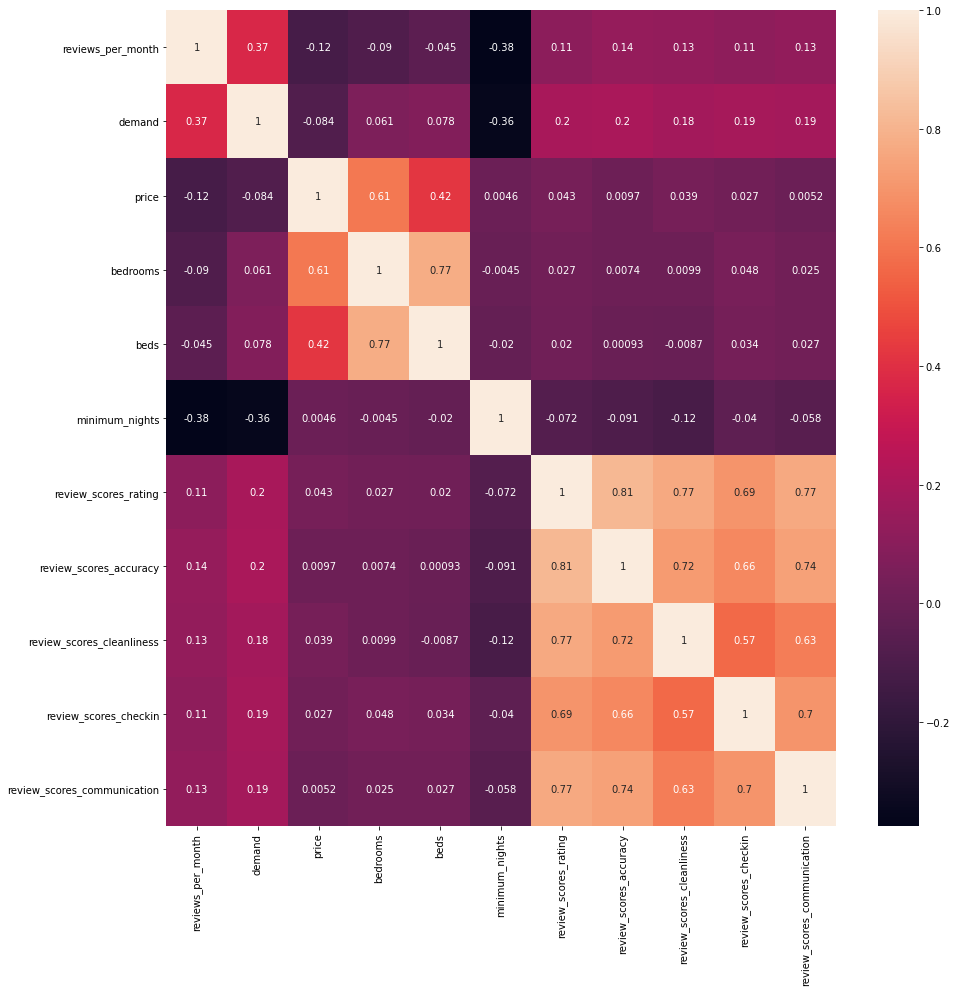

In [43]:
matrix = df.iloc[:,1:15].corr(method = 'pearson')
plt.figure(figsize=(15,15))
sns.heatmap(matrix, annot=True)
#plt.show()
plt.savefig('corr_map.png')

We see that Demand does not have a high correlation with other independent variables that we are using to build the model to predict demand therefore we can move on to building models to use all the variables to predict demand.

## XGBoost Regression for Demand Prediction

In [44]:
# conda install py-xgboost
import xgboost as xgb
from random import uniform
from random import randint
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [45]:
df.zipcode_large = [str(i) for i in df.zipcode_large]

In [46]:
df.columns

Index(['id', 'reviews_per_month', 'demand', 'price', 'neighbourhood_cleansed',
       'bedrooms', 'beds', 'room_type', 'minimum_nights', 'listing_url',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'host_since', 'calculated_host_listings_count',
       'accommodates', 'price_per_person', 'log_demand', 'zipcode',
       'housing_price', 'property_0', 'property_1', 'property_2', 'property_3',
       'property_4', 'property_5', 'property_6', 'property_7', 'property_8',
       'property_9', 'amenity_0', 'amenity_1', 'amenity_2', 'amenity_3',
       'amenity_4', 'amenity_5', 'amenity_6', 'amenity_7', 'amenity_8',
       'amenity_9', 'amenity_10', 'amenity_11', 'amenity_12', 'amenity_13',
       'amenity_14', 'amenity_15', 'amenity_16', 'amenity_17', 'amenity_18',
       'amenity_19', 'zipcode_large'],
      dtype='object')

In [47]:
df = df[df['demand'] > 0]

In [48]:
df = pd.merge(df4[['id','longitude', 'latitude']], df, on = ['id'])

In [49]:
model_df = df.drop(["id", "listing_url", "price", "neighbourhood_cleansed", "log_demand", "demand", "zipcode", "zipcode_large", "host_since"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(model_df, df['demand'], test_size=0.1, random_state=42)

In [50]:
model_df.columns

Index(['longitude', 'latitude', 'reviews_per_month', 'bedrooms', 'beds',
       'room_type', 'minimum_nights', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value',
       'calculated_host_listings_count', 'accommodates', 'price_per_person',
       'housing_price', 'property_0', 'property_1', 'property_2', 'property_3',
       'property_4', 'property_5', 'property_6', 'property_7', 'property_8',
       'property_9', 'amenity_0', 'amenity_1', 'amenity_2', 'amenity_3',
       'amenity_4', 'amenity_5', 'amenity_6', 'amenity_7', 'amenity_8',
       'amenity_9', 'amenity_10', 'amenity_11', 'amenity_12', 'amenity_13',
       'amenity_14', 'amenity_15', 'amenity_16', 'amenity_17', 'amenity_18',
       'amenity_19'],
      dtype='object')

In [53]:
cat_cols = X_train.columns[X_train.dtypes == 'object']
num_cols = X_train.columns[(X_train.dtypes == 'float64') | (X_train.dtypes == 'int64')]

In [54]:
enc_ohe = OneHotEncoder()
enc_ohe.fit(X_train[cat_cols])
def OneHotEncoding(df, enc, categories):  
    transformed = pd.DataFrame(enc.transform(df[categories]).toarray(), columns=enc.get_feature_names(categories))
    return pd.concat([df.reset_index(drop=True), transformed], axis=1).drop(categories, axis=1)
X_train = OneHotEncoding(X_train, enc_ohe, cat_cols)
X_test = OneHotEncoding(X_test, enc_ohe, cat_cols)

In [55]:
X_train

longitude  latitude  reviews_per_month  bedrooms  beds  minimum_nights  \
0    -118.33713  34.20694               1.19       3.0   3.0               2   
1    -118.11881  34.09500               3.95       1.0   1.0               1   
2    -118.25283  34.13877               4.94       2.0   2.0               2   
3    -118.59098  34.10102               2.87       1.0   1.0               2   
4    -117.91628  33.99046               1.86       1.0   2.0               1   
...         ...       ...                ...       ...   ...             ...   
3846 -118.34981  34.09659               0.12       2.0   2.0              30   
3847 -118.40176  33.93071               0.15       2.0   2.0               3   
3848 -118.31919  33.96381               4.08       1.0   1.0               1   
3849 -118.39533  33.84759               0.31       1.0   1.0               7   
3850 -118.35647  33.91190               3.91       2.0   3.0               2   

      review_scores_rating  review_scores_accuracy  review_scores_cleanliness  \
0                     99.0                    10.0                       10.0   
1                     93.0                    10.0                        9.0   
2                     97.0                    10.0                       10.0   
3                    100.0                    10.0                       10.0   
4                     96.0                    10.0                       10.0   
...                    ...                     ...                        ...   
3846                 100.0                    10.0                       10.0   
3847                 100.0                    10.0                       10.0   
3848                  96.0                    10.0                        9.0   
3849                 100.0                    10.0                       10.0   
3850                  97.0                    10.0                       10.0   

      review_scores_checkin  ...  amenity_14  amenity_15  amenity_16  \
0                      10.0  ...    0.044240    0.039159    0.042426   
1                      10.0  ...    0.163265    0.058834    0.212884   
2                      10.0  ...   -0.023893    0.268981    0.018140   
3                      10.0  ...   -0.069880   -0.006819    0.281394   
4                      10.0  ...   -0.221628   -0.039961    0.077988   
...                     ...  ...         ...         ...         ...   
3846                   10.0  ...    0.047425    0.139223    0.039921   
3847                   10.0  ...    0.046561    0.054095   -0.036020   
3848                   10.0  ...   -0.204440    0.234051   -0.001489   
3849                   10.0  ...   -0.074926   -0.074780    0.271602   
3850                   10.0  ...   -0.191084   -0.049859   -0.162009   

      amenity_17  amenity_18  amenity_19  room_type_Entire home/apt  \
0       0.171129   -0.092329   -0.035240                        1.0   
1      -0.082107   -0.049452   -0.020156                        0.0   
2       0.049733    0.141563    0.128534                        1.0   
3      -0.001159    0.025831   -0.145167                        1.0   
4       0.039391   -0.259358   -0.001170                        1.0   
...          ...         ...         ...                        ...   
3846   -0.121511   -0.109907   -0.034854                        1.0   
3847   -0.057836    0.068479    0.035303                        1.0   
3848   -0.023756    0.059722   -0.035497                        1.0   
3849    0.311237   -0.025348    0.116021                        0.0   
3850   -0.118707    0.100157    0.138799                        1.0   

      room_type_Hotel room  room_type_Private room  room_type_Shared room  
0                      0.0                     0.0                    0.0  
1                      0.0                     1.0                    0.0  
2                      0.0                     0.0                    0.0  
3                      0.0                     0.0

In [56]:
from sklearn.ensemble import GradientBoostingRegressor
params = {'learning_rate': np.arange(0.001, 0.1, (0.1-0.001)/5), # default 0.1 
          'max_depth': np.arange(2, 6, 1), # default 3
          'n_estimators': np.arange(100, 250, 50)}
xgb_model = xgb.XGBRegressor(random_state=42)

In [57]:
xgb_search = GridSearchCV(xgb_model, params, cv=5)

In [58]:
%time xgb_search.fit(X_train, y_train)

Wall time: 1min 38s


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=42,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parame

In [59]:
xgb_search.best_params_

{'learning_rate': 0.08020000000000001, 'max_depth': 5, 'n_estimators': 200}

### Residual Check

Residual of Test Dataset

<AxesSubplot:>

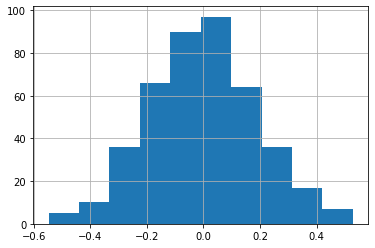

In [60]:
(xgb_search.predict(X_test)-y_test).hist()

Residual of Training Dataset

<AxesSubplot:>

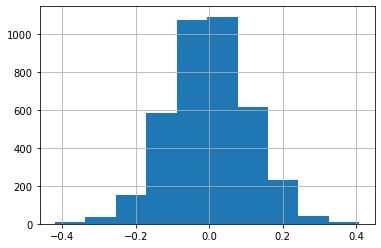

In [61]:
(xgb_search.predict(X_train) - y_train).hist()

## SHAP Value Analysis

In [62]:
import shap
from sklearn.model_selection import cross_validate

In [63]:
model = GradientBoostingRegressor(learning_rate=0.08020000000000001, 
                                  max_depth=5,
                                  n_estimators=200).fit(X_train, y_train)

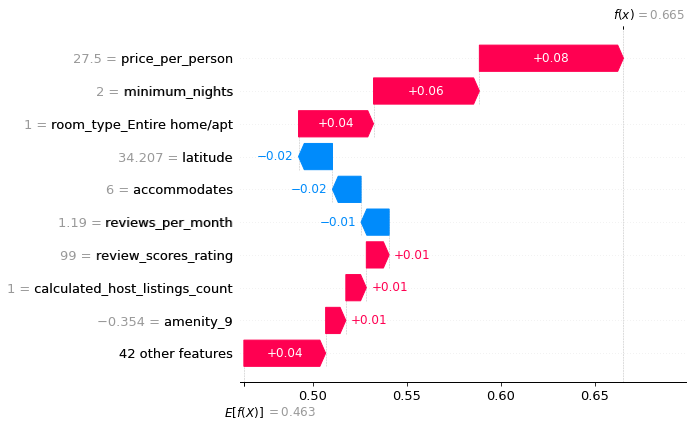

In [66]:
explainer = shap.TreeExplainer(xgb_search.best_estimator_)
shap_values = explainer(X_train)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0], max_display=10)

In [67]:
shap.initjs()
shap.plots.force(shap_values[0])

reviews_per_month

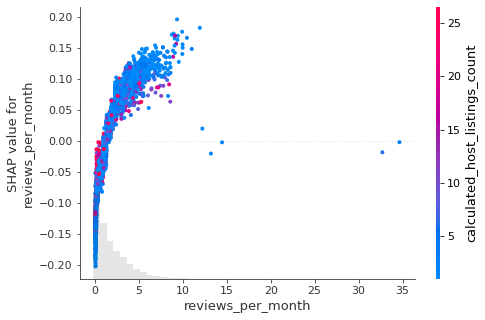

In [69]:
shap.plots.scatter(shap_values[:,"reviews_per_month"], color=shap_values)

price_per_person

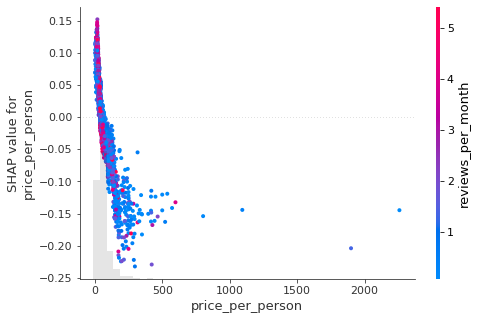

In [70]:
shap.plots.scatter(shap_values[:,"price_per_person"], color=shap_values)

reviews_per_month

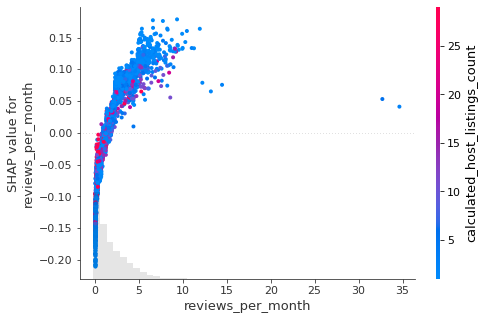

In [66]:
shap.plots.scatter(shap_values[:,"reviews_per_month"], color=shap_values)

### Spatial Analysis

In [71]:
from sklearn.inspection import partial_dependence
from sklearn.inspection import PartialDependenceDisplay
pdp = partial_dependence(
    model, X_train, features=['longitude', 'latitude'], kind="average", grid_resolution=100
)

Observed Demand Map

<Figure size 2160x2880 with 0 Axes>

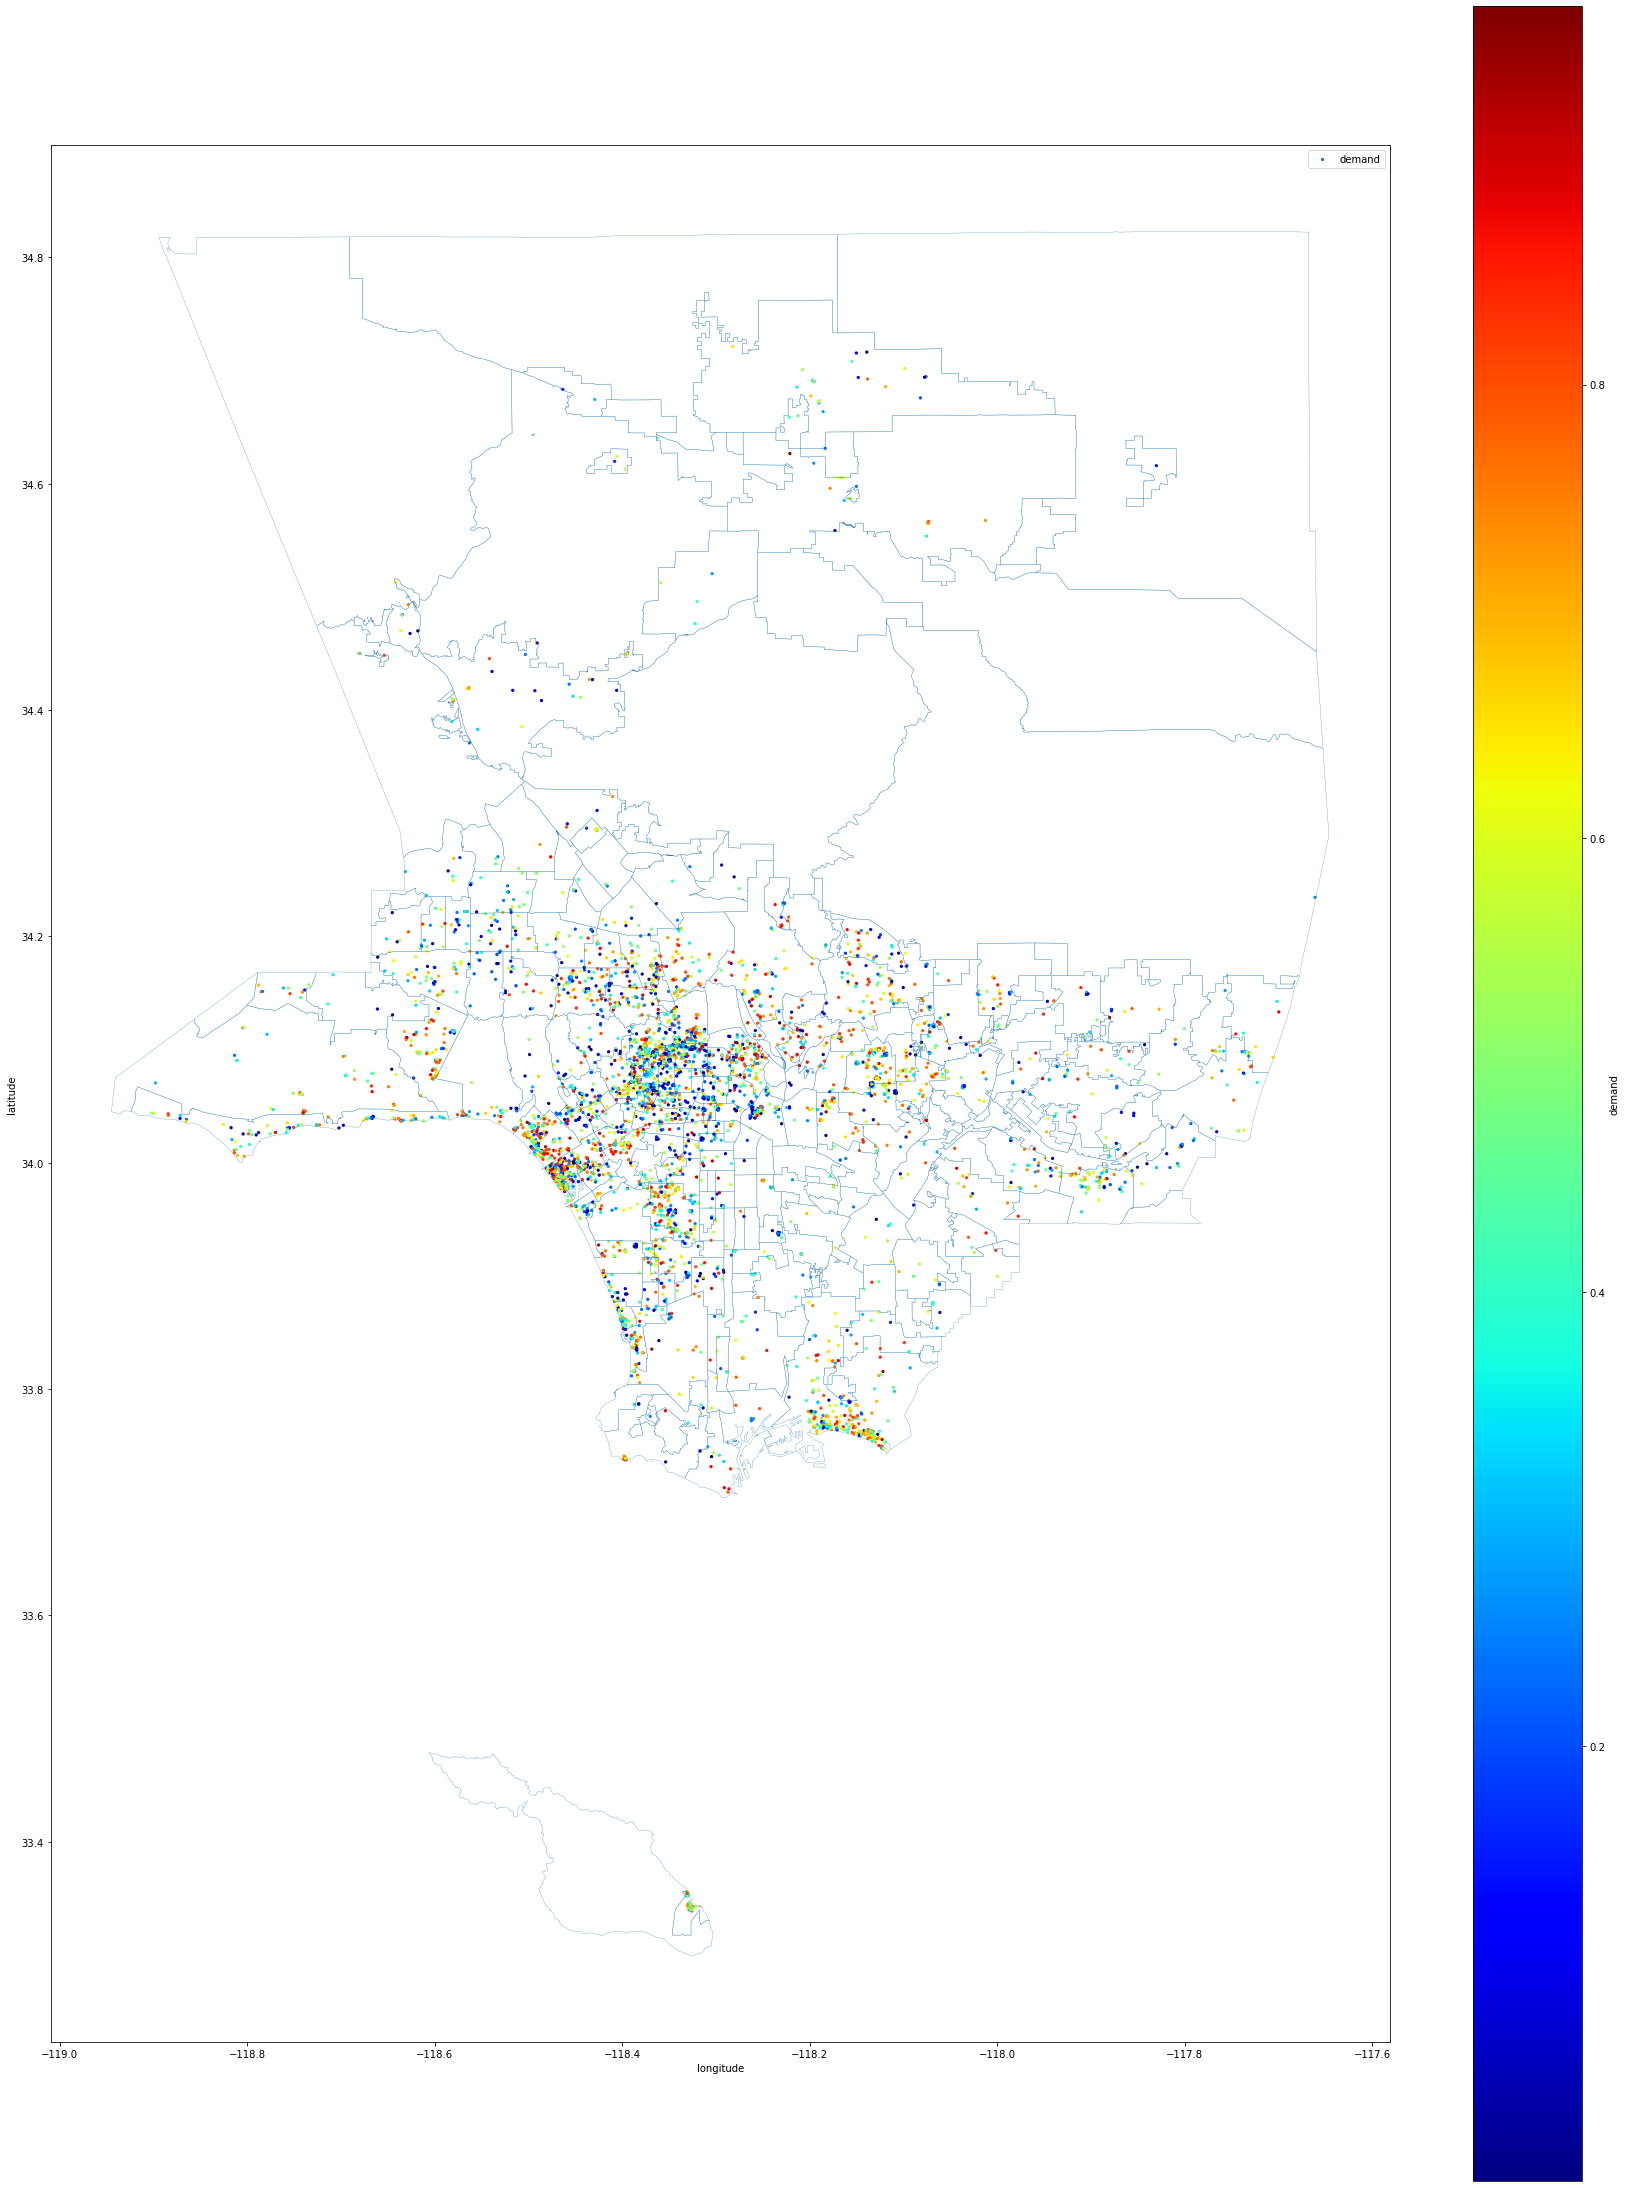

In [210]:
la_map = gpd.read_file('Data/neighbourhoods.geojson')

plt.figure(figsize=(30,40))
ax = la_map.boundary.plot(linewidth = 0.25)
ax.set_facecolor("white")
df.plot(kind='scatter', x='longitude', y='latitude', label='demand', c='demand',
                  cmap=plt.get_cmap('jet'), colorbar=True, alpha=1, s=  5, figsize=(30,40), ax=ax)

plt.legend()
plt.show()

Partial Dependence Plot of Spatial Impact on Demand

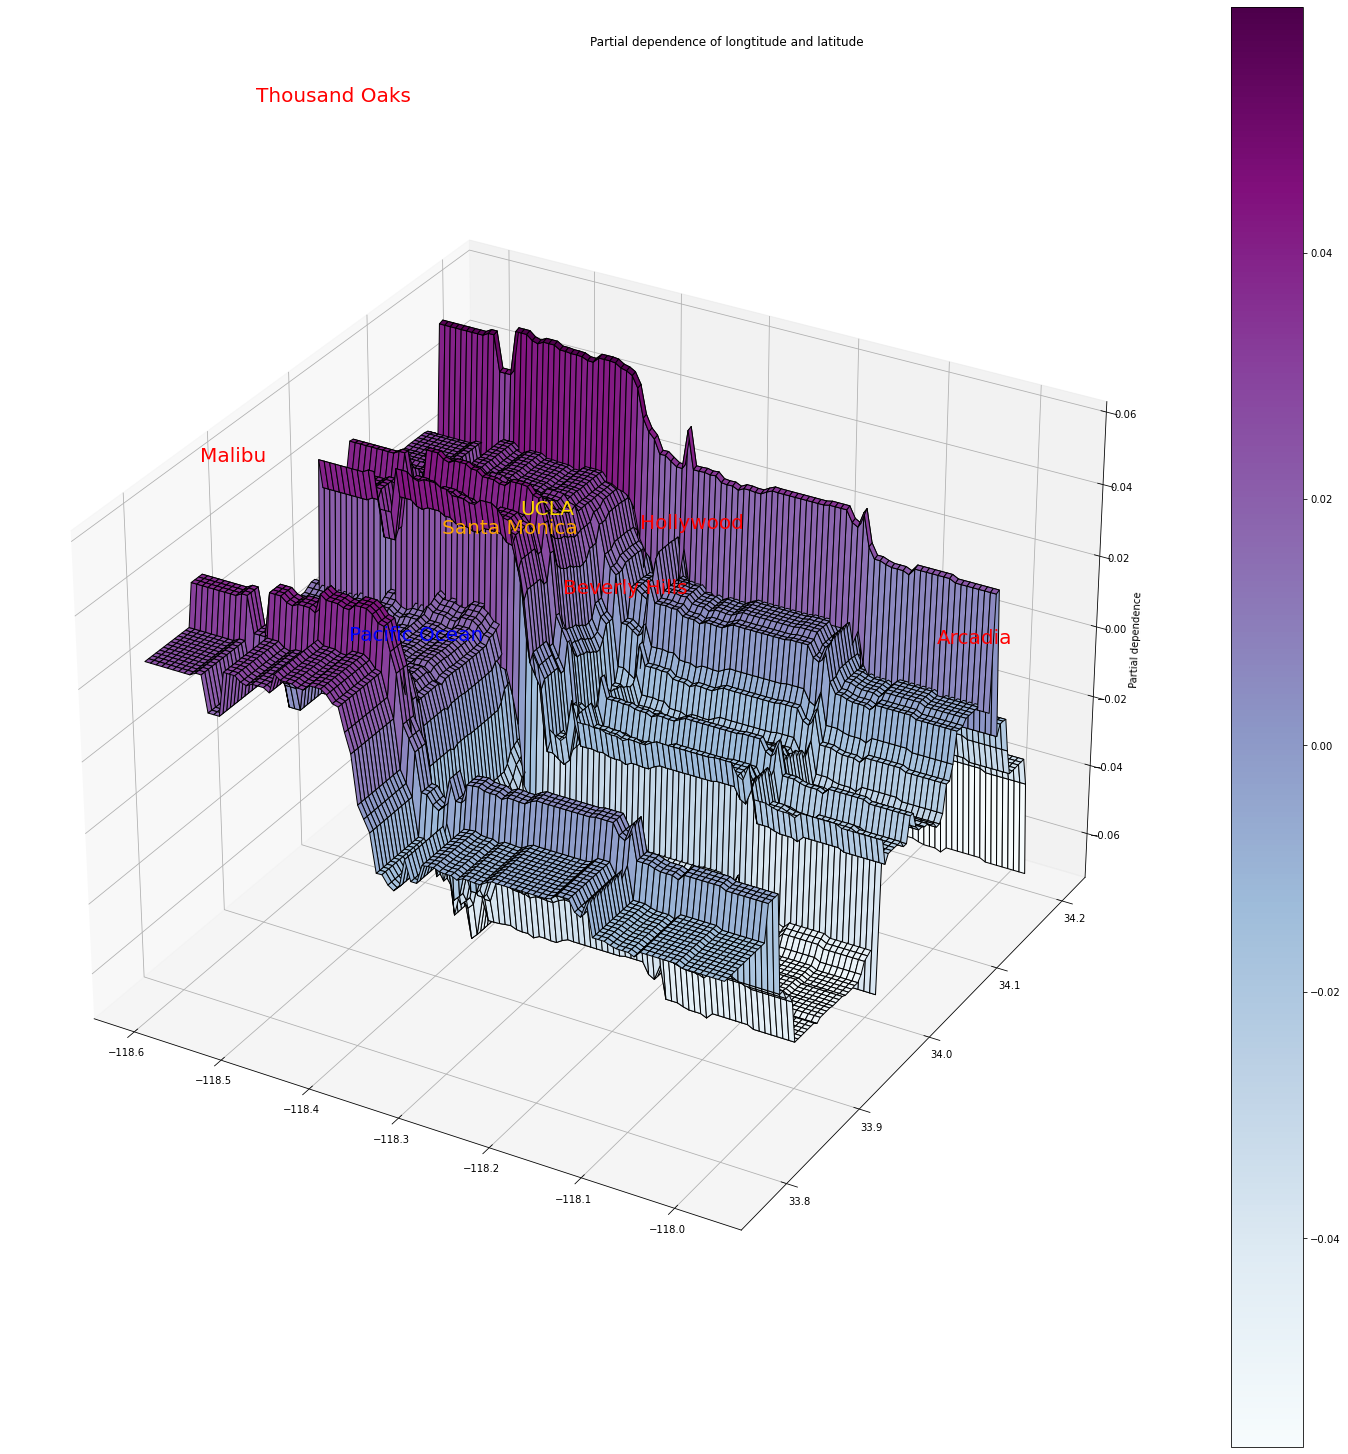

In [74]:
from mpl_toolkits.mplot3d import Axes3D
pdp = partial_dependence(
    model, X_train, features=['longitude', 'latitude'], kind="average", grid_resolution=100
)
fig = plt.figure(figsize=(20,20))
XX, YY = np.meshgrid(pdp["values"][0], pdp["values"][1])
Z = pdp.average[0].T
ax = Axes3D(fig)
ax.text(-118.3287, 34.0928,0.025, "Hollywood", color='red', fontsize = 20, alpha=1)
ax.text(-118.4452, 34.0689, 0.025, "UCLA", color='gold', fontsize = 20, alpha=1)
ax.text( -118.4912, 34.0195, 0.025, "Santa Monica", color='orange', fontsize = 20, alpha=1)
ax.text(-118.7798, 34.0259, 0.025, "Malibu", color='red', fontsize = 20, alpha=1)
ax.text(-118.0353,34.1397, 0.005, "Arcadia", color='red', fontsize = 20, alpha=1)
ax.text(-118.4004, 34.0736,0.005, "Beverly Hills", color='red', fontsize = 20, alpha=1)
ax.text(-118.8376, 34.1706, 0.10, "Thousand Oaks", color='red', fontsize = 20, alpha=1)
ax.text(-118.552225,  33.965270,0.00, "Pacific Ocean", color='blue', fontsize = 20, alpha=1)
surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=plt.cm.BuPu, edgecolor="k")
ax.set_zlabel("Partial dependence")
# pretty init view
plt.colorbar(surf)
plt.suptitle(
    "Partial dependence of longtitude and latitude"
)
#plt.show()
plt.savefig('pdp.png')

## XGBoost Regression for Revenue Prediction

In [75]:
## XGBoost Regression for Demand Predictionmodel_df = df.drop(["id", "listing_url", "price", "neighbourhood_cleansed", "log_demand", "demand", "zipcode","zipcode_large", "host_since"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(model_df, [x*y/housing_price*365 for x,y,housing_price in zip(df['price'], df['demand'],df['housing_price'])], test_size=0.1, random_state=42)

# model_df.to_csv("cleaned_data.csv")

cat_cols = X_train.columns[X_train.dtypes == 'object']
num_cols = X_train.columns[(X_train.dtypes == 'float64') | (X_train.dtypes == 'int64')]

enc_ohe = OneHotEncoder()
enc_ohe.fit(X_train[cat_cols])
def OneHotEncoding(df, enc, categories):  
    transformed = pd.DataFrame(enc.transform(df[categories]).toarray(), columns=enc.get_feature_names(categories))
    return pd.concat([df.reset_index(drop=True), transformed], axis=1).drop(categories, axis=1)
X_train = OneHotEncoding(X_train, enc_ohe, cat_cols)
X_test = OneHotEncoding(X_test, enc_ohe, cat_cols)

In [77]:
from sklearn.ensemble import GradientBoostingRegressor
params = {'learning_rate': np.arange(0.001, 0.1, (0.1-0.001)/5), # default 0.1 
          'max_depth': np.arange(2, 6, 1), # default 3
          'n_estimators': np.arange(100, 250, 50)}
xgb_model = xgb.XGBRegressor(random_state=42)

xgb_search = GridSearchCV(xgb_model, params, cv=5)

%time xgb_search.fit(X_train, y_train)

Wall time: 1min 36s


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=42,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parame

In [79]:
xgb_search.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.08020000000000001, max_delta_step=0, max_depth=4,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=16, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [80]:
model = GradientBoostingRegressor(learning_rate=0.08020000000000001, 
                                  max_depth=5,
                                  n_estimators=200).fit(X_train, y_train)

### Residual Check

Residual of test set

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  2.,  1.,  1.,  0.,  0.,  2.,  2.,  0.,  2.,  0.,  3.,
         1.,  1.,  0.,  2.,  3.,  3.,  3.,  5.,  5.,  5., 12., 16., 15.,
        37., 66., 53., 53., 40., 24., 17., 12., 10.,  4.,  1.,  1.,  4.,
         7.,  4.,  1.,  1.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,  1.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  1.]),
 array([-2.30478946, -2.27061902, -2.23644858, -2.20227814, -2.1681077 ,
        -2.13393727, -2.09976683, -2.06559639, -2.03142595, -1.99725551,
        -1.96308507, -1.92891463, -1.89474419, -1.86057375, -1.82640331,
        -1.79223287, -1.75806243, -1.723892  , -1.68972156, -1.65555112,
        -1.

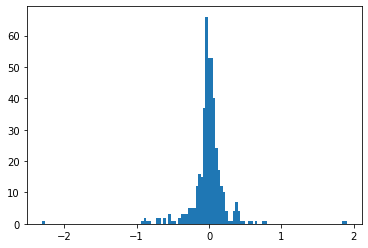

In [85]:
plt.hist(xgb_search.best_estimator_.predict(X_test) - y_test, bins='auto')

Residual for training set

(array([  1.,   0.,   1.,   1.,   0.,   0.,   1.,   1.,   0.,   0.,   0.,
          1.,   0.,   1.,   0.,   1.,   1.,   2.,   0.,   0.,   0.,   0.,
          2.,   1.,   3.,   3.,   1.,   1.,   1.,   0.,   2.,   1.,   3.,
          0.,   5.,   5.,   6.,   3.,   5.,   5.,   7.,   4.,   8.,  11.,
         12.,   9.,  13.,  14.,  25.,  14.,  11.,  21.,  21.,  30.,  25.,
         31.,  39.,  35.,  53.,  61.,  68.,  78., 107., 128., 165., 252.,
        264., 301., 315., 271., 212., 174., 162., 116., 108.,  79.,  78.,
         65.,  58.,  49.,  46.,  25.,  20.,  23.,  24.,  11.,  17.,  13.,
         14.,  13.,  10.,   9.,  10.,   6.,   7.,   4.,   6.,   5.,   4.,
          4.,   4.,   1.,   3.,   4.,   3.,   1.,   2.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   1.,   1.,   1.,   0.,   0.,   0.,   1.,
          0.,   0.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,
          1.]),
 array([-1.02017374, -

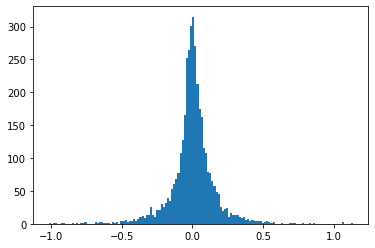

In [86]:
plt.hist(xgb_search.best_estimator_.predict(X_train) - y_train, bins='auto')

Overfitting is more serious here than demand prediction and it makes sense: demand ranges from 0 - 1, while roi ranges from 0 to infinity.

## SHAP Analysis 2

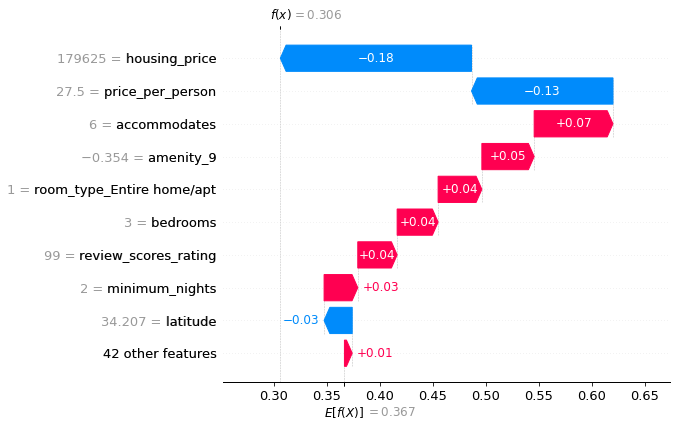

In [87]:
explainer = shap.TreeExplainer(xgb_search.best_estimator_)
shap_values = explainer(X_train)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

In [88]:
shap.initjs()
shap.plots.force(shap_values[0])

room_type: being an entire home or not

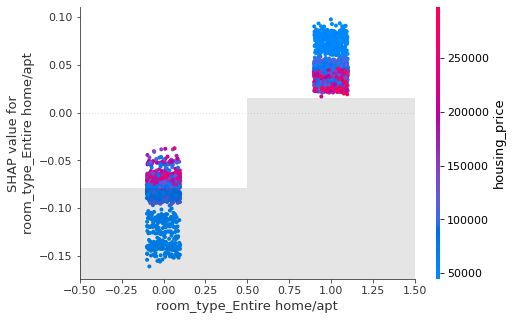

In [96]:
shap.plots.scatter(shap_values[:,"room_type_Entire home/apt"], color=shap_values)

price_per_person

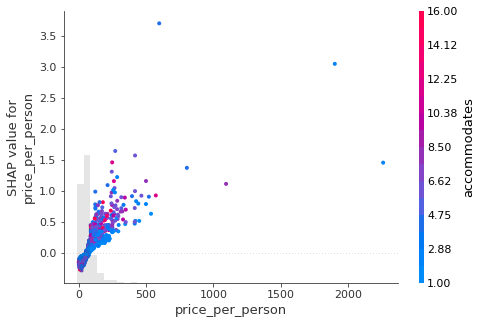

In [89]:
shap.plots.scatter(shap_values[:,"price_per_person"], color=shap_values)

Housing Price

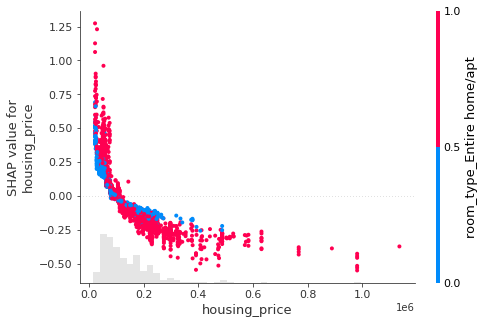

In [95]:
shap.plots.scatter(shap_values[:,"housing_price"], color=shap_values)

Number of guests per night

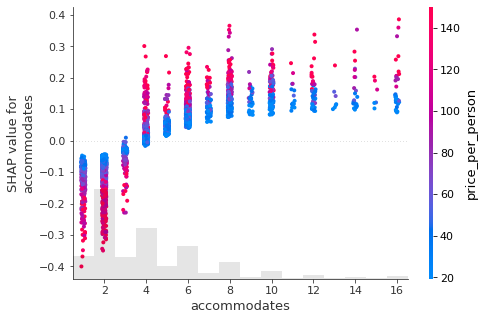

In [98]:
shap.plots.scatter(shap_values[:,"accommodates"], color=shap_values)

### Spatial Analysis 2

Observed ROI Map

<Figure size 2160x2880 with 0 Axes>

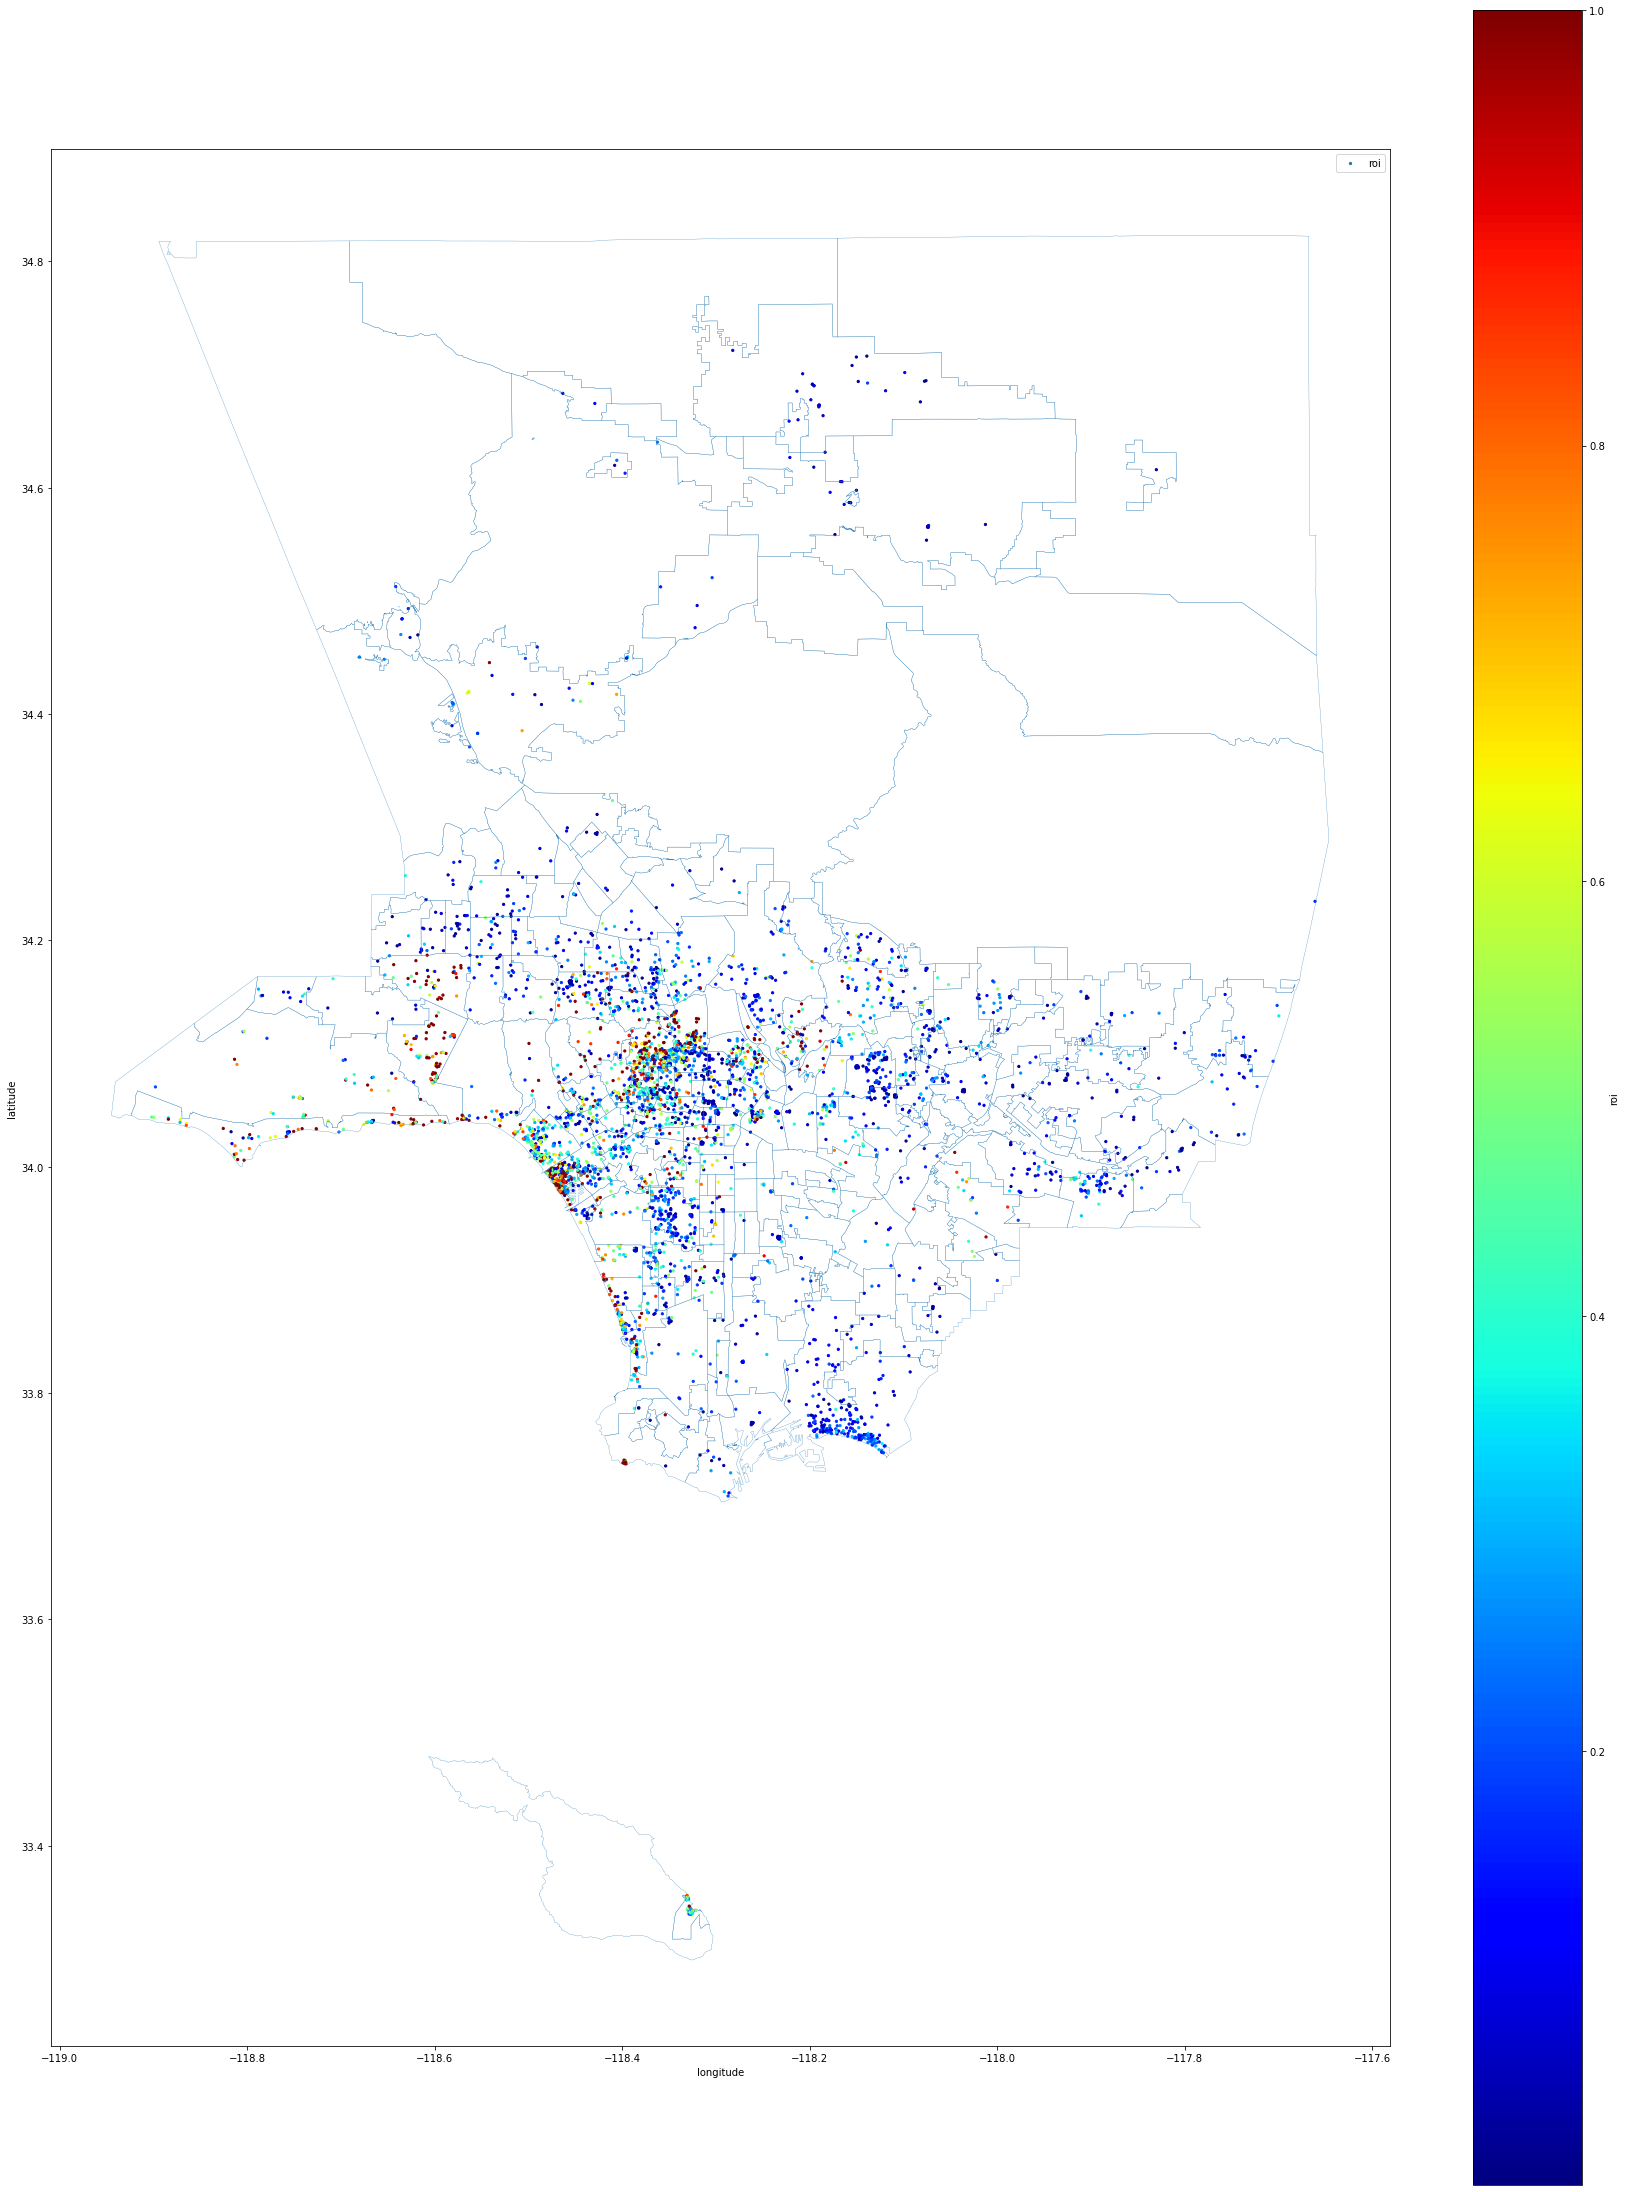

In [100]:
df_location = pd.merge(df4[['id','longitude', 'latitude']], df,on = ['id'])
df['roi'] =  [x*y/housing_price*365 for x,y,housing_price in zip(df['price'], df['demand'],df['housing_price'])]

la_map = gpd.read_file('Data/neighbourhoods.geojson')
df['roi'][df['roi']>1]=1
plt.figure(figsize=(30,40))
ax = la_map.boundary.plot(linewidth = 0.25)
ax.set_facecolor("white")
df.plot(kind='scatter', x='longitude', y='latitude', label='roi', c='roi',
                  cmap=plt.get_cmap('jet'), colorbar=True, alpha=1, s=  5, figsize=(30,40), ax=ax)

plt.legend()
plt.savefig('pdp.png')

Partial Dependence Plot of Spatial Impact on ROI

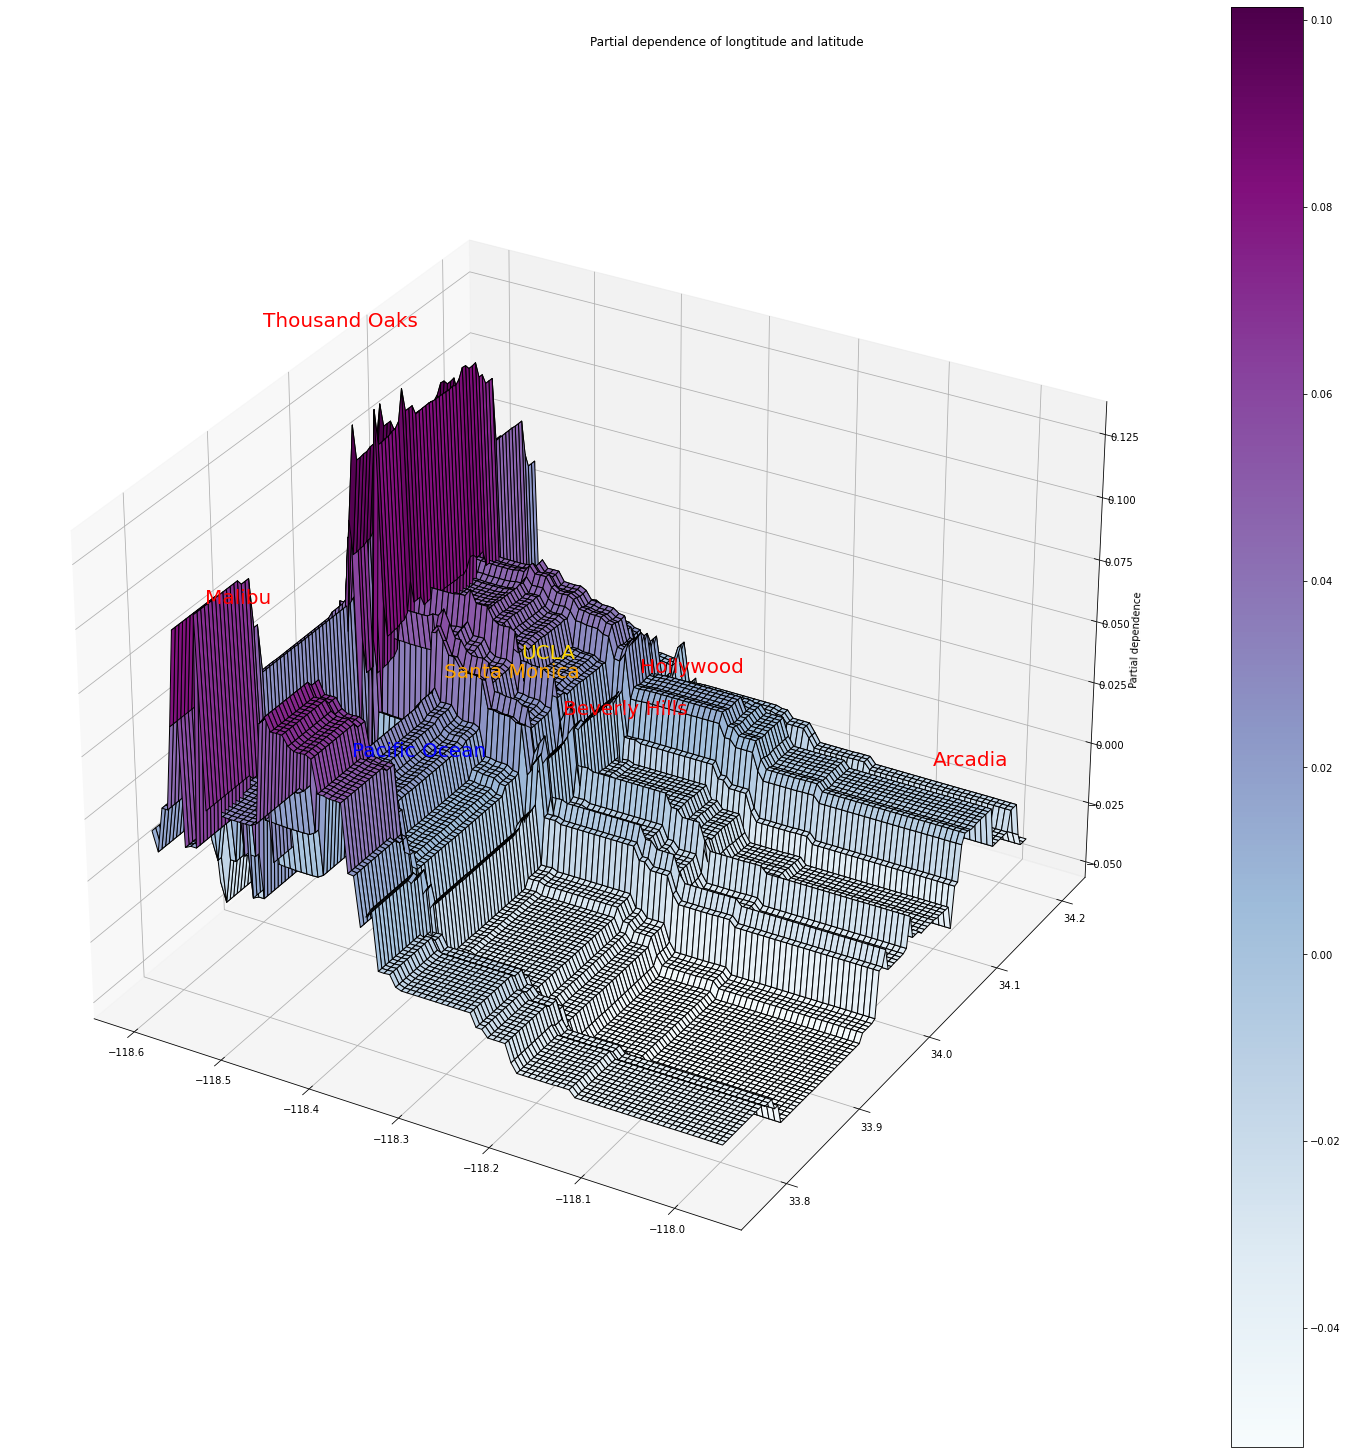

In [102]:
from mpl_toolkits.mplot3d import Axes3D
pdp = partial_dependence(
    model, X_train, features=['longitude', 'latitude'], kind="average", grid_resolution=100
)
fig = plt.figure(figsize=(20,20))
XX, YY = np.meshgrid(pdp["values"][0], pdp["values"][1])
Z = pdp.average[0].T
ax = Axes3D(fig)
ax.text(-118.3287, 34.0928,0.025, "Hollywood", color='red', fontsize = 20, alpha=1)
ax.text(-118.4452, 34.0689, 0.025, "UCLA", color='gold', fontsize = 20, alpha=1)
ax.text( -118.4912, 34.0195, 0.025, "Santa Monica", color='orange', fontsize = 20, alpha=1)
ax.text(-118.7798, 34.0259, 0.025, "Malibu", color='red', fontsize = 20, alpha=1)
ax.text(-118.0353,34.1397, 0.005, "Arcadia", color='red', fontsize = 20, alpha=1)
ax.text(-118.4004, 34.0736,0.005, "Beverly Hills", color='red', fontsize = 20, alpha=1)
ax.text(-118.8376, 34.1706, 0.10, "Thousand Oaks", color='red', fontsize = 20, alpha=1)
ax.text(-118.552225,  33.965270,0.00, "Pacific Ocean", color='blue', fontsize = 20, alpha=1)
surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=plt.cm.BuPu, edgecolor="k")
ax.set_zlabel("Partial dependence")
# pretty init view
plt.colorbar(surf)
plt.suptitle(
    "Partial dependence of longtitude and latitude"
)
#plt.show()
plt.savefig('pdp.png')
